In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
def get_melted_pi_counts_table(ver='poder', min_t_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='t_tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    
    # add gene expression
    ver = 'poder'
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tsv'],od))[0]
    gene_df = pd.read_csv(f, sep='\t')
    gene_df.head()
    gene_df.sort_values(by='geneid.v').head()
    gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
    id_vars = ['gid']
    sample_columns = list(set(gene_df.columns)-set(id_vars))
    gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='g_counts')
    gene_df.head()
    
    # filter based on min. cpm
    df = df.merge(gene_df, how='left',
                  on=['gid', 'sample'])
    
    
    if min_t_cpm:
        df = df.loc[df.t_tpm >= min_t_cpm]
        
    return df

In [4]:
# get predominant transcripts for poder
df = get_melted_pi_counts_table('poder')

In [5]:
# remove anything w/ 0 pi val
# can adjust this threshold later if needed
df = df.loc[df.pi>0]

# keep transcripts that have at least 11 samples with more than 0.1 cpm
t_cpm_thresh = 0.1
n_t_sample_thresh = 11
temp = df[['sample', 'tid', 't_tpm']]
temp = temp.loc[temp['t_tpm']>=t_cpm_thresh]
temp = temp.drop('t_tpm', axis=1)
temp = temp.groupby('tid').nunique().reset_index().rename({'sample':'n_t_samples'}, axis=1)
df = df.merge(temp, how='left', on='tid')

# keep genes with at least 11 samples with at least 10 counts
g_counts_thresh = 10
n_g_sample_thresh = 11
temp = df[['sample', 'gid', 'g_counts']]
temp = temp.loc[temp.g_counts>=g_counts_thresh]
temp = temp.drop('g_counts', axis=1)
temp = temp.groupby('gid').nunique().reset_index().rename({'sample':'n_g_samples'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# keep genes with more than 1 transcript
temp = df[['tid', 'gid']].groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# perform the filtering
df = df.loc[df.n_t_samples>=n_t_sample_thresh]
df = df.loc[df.n_g_samples>=n_g_sample_thresh]
df = df.loc[df.n_t>1]

In [6]:
df.head()

,tid,gid,sample,pi,t_tpm,population,g_counts,n_t_samples,n_g_samples,n_t
0,ENST00000010132.6,ENSG00000010219.14,YRI6,0.489853,20.133300,YRI,363.082160,43.0,43.0,17
3,ENST00000214893.10,ENSG00000099219.15,YRI6,1.000000,0.226399,YRI,2.000000,38.0,16.0,7
4,ENST00000220966.10,ENSG00000104524.14,YRI6,0.500000,0.396198,YRI,7.000000,30.0,31.0,4
5,ENST00000222572.8,ENSG00000105854.13,YRI6,0.333333,0.037733,YRI,0.999999,15.0,11.0,5
6,ENST00000224756.12,ENSG00000107771.17,YRI6,0.500000,0.226399,YRI,4.000000,19.0,20.0,6


In [7]:
# # verify gene transform
# len(df.loc[(df.gid=='ENSG00000000419.14')&(df.g_counts>=g_cpm_thresh)]['sample'].unique())
# gid = 'ENSG00000002016.18'
# len(df.loc[(df.gid==gid)&(df.g_counts>=g_cpm_thresh)]['sample'].unique())
# gid = 'ENSG00000038427.16'
# len(df.loc[(df.gid==gid)&(df.g_counts>=g_cpm_thresh)]['sample'].unique())

In [8]:
# # verify t transform
# len(df.loc[(df.tid=='ENST00000010132.6')&(df.tpm>=t_cpm_thresh)])
# len(df.loc[(df.tid=='ENST00000155093.8')&(df.tpm>=t_cpm_thresh)])

In [9]:
# groupby sample and gene to compute entropy 
# over pi values
e_df = df[['gid', 'sample',
           'pi', 'population', 'n_t']].groupby(['gid', 'sample',
                                         'population', 'n_t']).apply(lambda x: st.entropy(x.pi))
e_df = e_df.reset_index().rename({0:'entropy'}, axis=1)

In [10]:
e_df.head(1)

,gid,sample,population,n_t,entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324


In [11]:
# validate that this worked
temp_list = df.loc[(df['sample']=='AJI1')&(df.gid=='ENSG00000000419.14')].pi.tolist()
st.entropy(temp_list)

0.6093237555894174

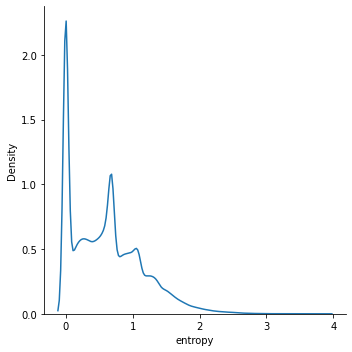

In [12]:
# plot distribution of entropies
sns.displot(e_df, kind='kde', x='entropy')

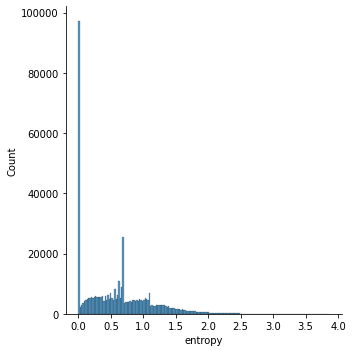

In [13]:
# plot distribution of entropies
sns.displot(e_df, kind='hist', x='entropy')
# peaks are probably at the different theoretical maxes maybe?

In [14]:
# get # isoforms expressed vs. entropy
n_t_df = df[['tid', 'gid', 'sample']].groupby(['gid', 'sample']).nunique().reset_index().rename({'tid': 'n_exp_t'}, axis=1)
e_df = e_df.merge(n_t_df, on=['gid', 'sample'])

In [15]:
# # remove genes w/ just one isofomr
# print(len(e_df.index))
# e_df = e_df.loc[e_df.n_t!=1]
# print(len(e_df.index))

In [16]:
df.loc[(df.gid=='ENSG00000238260.4')&(df['sample']=='AJI2')]

,tid,gid,sample,pi,t_tpm,population,g_counts,n_t_samples,n_g_samples,n_t


In [17]:
e_df.loc[(e_df.gid=='ENSG00000238260.4')&(e_df['sample']=='AJI2')]

,gid,sample,population,n_t,entropy,n_exp_t


In [18]:
# e_df.rename({'n_t_x':'n_t'}, axis=1, inplace=True)
# e_df.drop('n_t_y', axis=1, inplace=True)

In [19]:
e_df.head()

,gid,sample,population,n_t,entropy,n_exp_t
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15


In [20]:
# normalize entropy values to max entropy values computed using 
# this stragtegy
# https://mc-stan.org/posterior/reference/entropy.html
e_df['norm_entropy'] = e_df.entropy/np.log(e_df.n_t)

In [21]:
e_df.head(1)

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729


In [22]:
# check to make sure it worked
print(0.609324/np.log(24))
print(e_df.head())

0.19172865927613592
                  gid sample population  n_t   entropy  n_exp_t  norm_entropy
0  ENSG00000000419.14   AJI1        AJI   24  0.609324       12      0.191729
1  ENSG00000000419.14   AJI2        AJI   24  0.821625       12      0.258531
2  ENSG00000000419.14   AJI3        AJI   24  0.709283       14      0.223182
3  ENSG00000000419.14   AJI4        AJI   24  0.636257       11      0.200203
4  ENSG00000000419.14   AJI5        AJI   24  0.785144       15      0.247052


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


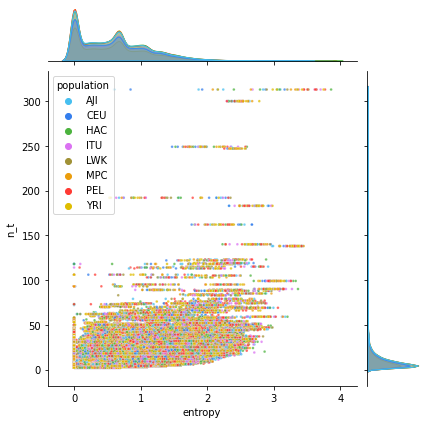

In [23]:
# plot
c_dict, order = get_population_colors()
sns.jointplot(e_df, x='entropy', y='n_t', hue='population', palette=c_dict,
              alpha=0.75, s=7)

In [25]:
e_df.to_csv('241021_entropy_summary.tsv', sep='\t', index=False)

Text(2, 95, 'y = 4.051 + 10.287x')

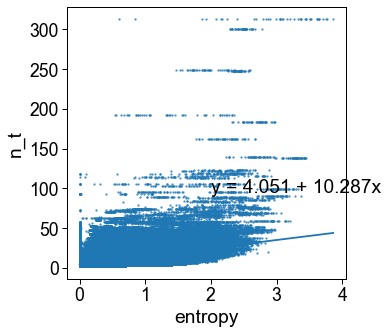

In [26]:
# plot
init_plot_settings(aspect='square')
p = sns.regplot(e_df, x='entropy', y='n_t', scatter_kws={'s': 2,
                                                         'alpha': 0.6})

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = st.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#add regression equation to plot
plt.text(2, 95, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')

In [27]:
# what are these outliers?
print(len(e_df.loc[e_df.n_t>150]))
print(len(e_df.loc[e_df.n_t>150].gid.unique()))
print(e_df.loc[e_df.n_t>150].gid.unique())
print(e_df.loc[e_df.n_t>150][['sample', 'gid']].groupby('gid').count())

301
7
['ENSG00000223482.11' 'ENSG00000226777.10' 'ENSG00000234741.11'
 'ENSG00000249859.15' 'ENSG00000255717.10' 'ENSG00000291178.2'
 'ENSG00000304176.1']
                    sample
gid                       
ENSG00000223482.11      43
ENSG00000226777.10      43
ENSG00000234741.11      43
ENSG00000249859.15      43
ENSG00000255717.10      43
ENSG00000291178.2       43
ENSG00000304176.1       43


In [28]:
# lets try to look at some more reasonable exmples,
# maybe genes w/ <10 transcripts and high entropy
# lets say >2
temp = e_df.loc[e_df.n_t<10]
temp = temp.loc[temp.entropy>2]
temp.sort_values(by='entropy', ascending=False).head()
print(len(temp.index))
print(len(temp.gid.unique()))

# nearly half of genes in this category are repeated across samples
temp.head()

11
5


,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
99271,ENSG00000112031.16,HAC2,HAC,8,2.020673,8,0.971738
99279,ENSG00000112031.16,ITU4,ITU,8,2.039716,8,0.980896
99280,ENSG00000112031.16,ITU5,ITU,8,2.024069,8,0.973372
99293,ENSG00000112031.16,PEL4,PEL,8,2.027025,8,0.974793
272528,ENSG00000166925.9,HAC2,HAC,9,2.060610,8,0.937824


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


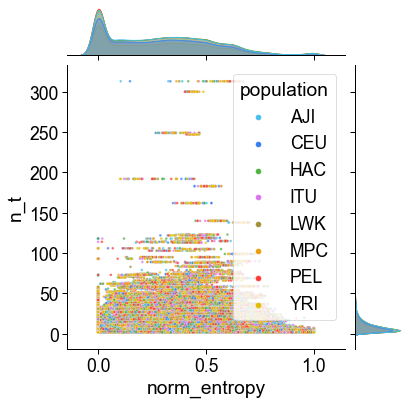

In [29]:
# normalized
# plot
c_dict, order = get_population_colors()
sns.jointplot(e_df, x='norm_entropy', y='n_t', hue='population', palette=c_dict,
              alpha=0.75, s=7)

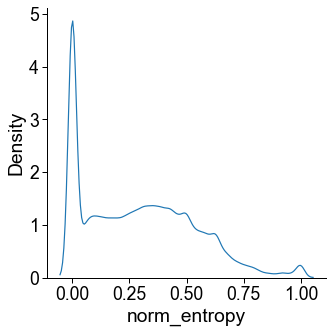

In [30]:
# plot distribution of entropies
sns.displot(e_df, kind='kde', x='norm_entropy')

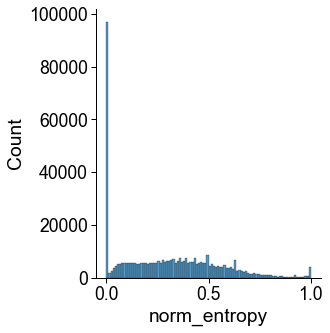

In [31]:
# plot distribution of entropies
sns.displot(e_df, kind='hist', x='norm_entropy')
# peaks are probably at the different theoretical maxes maybe?

In [32]:
e_df.head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.258531
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.223182
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.200203
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.247052


In [33]:
e_df.sort_values(by='norm_entropy', ascending=False)

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
297390,ENSG00000172780.17,ITU1,ITU,5,1.609438,5,1.0
221914,ENSG00000151348.16,HAC5,HAC,5,1.609438,5,1.0
221911,ENSG00000151348.16,HAC2,HAC,5,1.609438,5,1.0
221936,ENSG00000151348.16,YRI1,YRI,5,1.609438,5,1.0
221931,ENSG00000151348.16,PEL2,PEL,5,1.609438,5,1.0
...,...,...,...,...,...,...,...
371641,ENSG00000215424.11,YRI6,YRI,16,0.000000,1,0.0
259032,ENSG00000164114.19,YRI5,YRI,7,0.000000,1,0.0
259031,ENSG00000164114.19,YRI2,YRI,7,0.000000,1,0.0
259030,ENSG00000164114.19,YRI1,YRI,7,0.000000,1,0.0


In [34]:
df.loc[(df.gid=='ENSG00000238260.4')&(df['sample']=='AJI3')]

,tid,gid,sample,pi,t_tpm,population,g_counts,n_t_samples,n_g_samples,n_t


In [40]:
## what do PI values look like across the low entrop. samples
e_df.loc[(e_df.norm_entropy>0)&(e_df.norm_entropy<0.2)].head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729
5,ENSG00000000419.14,AJI6,AJI,24,0.591994,13,0.186276
19,ENSG00000000419.14,ITU3,ITU,24,0.573359,13,0.180412
23,ENSG00000000419.14,LWK2,LWK,24,0.498447,14,0.156840
32,ENSG00000000419.14,PEL2,PEL,24,0.478011,10,0.150410


In [44]:
df.loc[(df.gid=='ENSG00000000419.14')&(df['sample']=='AJI1')]

,tid,gid,sample,pi,t_tpm,population,g_counts,n_t_samples,n_g_samples,n_t
789701,transcript_306672,ENSG00000000419.14,AJI1,0.004506,0.286350,AJI,717.0002,12.0,43.0,24
789705,transcript_306715,ENSG00000000419.14,AJI1,0.007557,0.480225,AJI,717.0002,31.0,43.0,24
789707,transcript_306721,ENSG00000000419.14,AJI1,0.001951,0.124009,AJI,717.0002,41.0,43.0,24
789708,transcript_306722,ENSG00000000419.14,AJI1,0.004887,0.310544,AJI,717.0002,42.0,43.0,24
789709,transcript_306731,ENSG00000000419.14,AJI1,0.006263,0.398027,AJI,717.0002,41.0,43.0,24
789710,transcript_306736,ENSG00000000419.14,AJI1,0.871828,55.405100,AJI,717.0002,43.0,43.0,24
789711,transcript_306737,ENSG00000000419.14,AJI1,0.002441,0.155096,AJI,717.0002,39.0,43.0,24
789712,transcript_306738,ENSG00000000419.14,AJI1,0.007266,0.461788,AJI,717.0002,37.0,43.0,24
789714,transcript_306741,ENSG00000000419.14,AJI1,0.035469,2.254060,AJI,717.0002,43.0,43.0,24
789715,transcript_306742,ENSG00000000419.14,AJI1,0.048539,3.084660,AJI,717.0002,43.0,43.0,24


In [42]:
## what do PI values look like across the low entrop. samples
e_df.loc[(e_df.norm_entropy>.8)*(e_df.n_t>5)].head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
371,ENSG00000001461.18,MPC1,MPC,7,1.557225,6,0.800255
374,ENSG00000001461.18,MPC4,MPC,7,1.617520,6,0.831241
378,ENSG00000001461.18,PEL4,PEL,7,1.588480,5,0.816317
2853,ENSG00000005889.16,LWK1,LWK,7,1.599971,5,0.822223
2866,ENSG00000005889.16,PEL5,PEL,7,1.564654,5,0.804073


In [45]:
gid = 'ENSG00000001461.18'
sample = 'MPC1'
df.loc[(df.gid==gid)&(df['sample']==sample)]

,tid,gid,sample,pi,t_tpm,population,g_counts,n_t_samples,n_g_samples,n_t
2095225,transcript_11363,ENSG00000001461.18,MPC1,0.250000,0.400520,MPC,16.0,42.0,42.0,7
2095226,transcript_11364,ENSG00000001461.18,MPC1,0.062500,0.100130,MPC,16.0,32.0,42.0,7
2095228,transcript_11365,ENSG00000001461.18,MPC1,0.103125,0.165215,MPC,16.0,14.0,42.0,7
2095238,transcript_11368,ENSG00000001461.18,MPC1,0.401042,0.642501,MPC,16.0,41.0,42.0,7
2095240,transcript_11369,ENSG00000001461.18,MPC1,0.103125,0.165215,MPC,16.0,41.0,42.0,7
2095242,transcript_11370,ENSG00000001461.18,MPC1,0.080208,0.128500,MPC,16.0,15.0,42.0,7


In [62]:
# ## just look at the displot of entropies across populations
# c_dict, order = get_population_colors()
# init_plot_settings()
# plt.figure(figsize=(10,6))
# # sns.displot(e_df, x='norm_entropy', hue='population', palette=c_dict, kind='kde', common_norm=False)

# # Initialize the FacetGrid object
# g = sns.FacetGrid(e_df, row="population", hue="population", aspect=15, height=2, palette=c_dict)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "norm_entropy",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "norm_entropy", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "norm_entropy")

# # Set the subplots to overlap
# g.figure.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)

In [65]:
e_df.head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.258531
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.223182
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.200203
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.247052


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


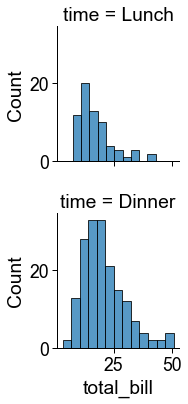

In [75]:
tips = sns.load_dataset("tips")

g = sns.FacetGrid(tips, row="time")
g.map_dataframe(sns.histplot, x="total_bill")
tips.head()

In [72]:
e_df.head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.258531
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.223182
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.200203
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.247052


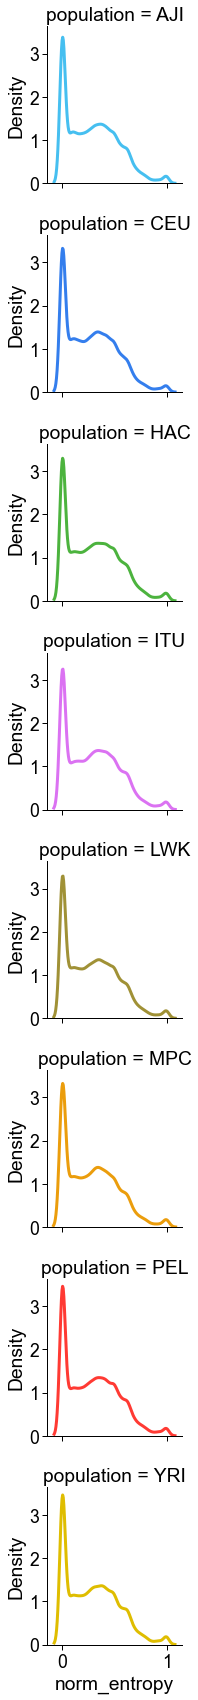

In [83]:
init_plot_settings('square')
# g = sns.FacetGrid(e_df,  row='population') #, hue='population', palette=c_dict)
# g.map(sns.histplot, x='norm_entropy')
g = sns.FacetGrid(e_df, row='population')
g.map_dataframe(sns.kdeplot, x='norm_entropy', hue='population', palette=c_dict, linewidth=3)

## stats???

In [85]:
import pandas as pd
import statsmodels.formula.api as smf

model = smf.mixedlm('norm_entropy ~ population', e_df, groups=e_df['gid'])
result = model.fit()
print(result.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  norm_entropy
No. Observations:  454431   Method:              REML        
No. Groups:        10678    Scale:               0.0210      
Min. group size:   14       Log-Likelihood:      209559.5876 
Max. group size:   43       Converged:           Yes         
Mean group size:   42.6                                      
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          0.291    0.002 147.755 0.000  0.287  0.295
population[T.CEU] -0.006    0.001  -7.032 0.000 -0.008 -0.004
population[T.HAC]  0.006    0.001   7.435 0.000  0.004  0.008
population[T.ITU]  0.005    0.001   6.164 0.000  0.004  0.007
population[T.LWK] -0.001    0.001  -0.790 0.429 -0.002  0.001
population[T.MPC] -0.006    0.001  -7.001 0.000 -0.008 -0.005
population[T.PEL]  0

## How does entropy relate to gene expression?